Introduction

The capabilities of artificial intelligence in image processing and generation have seen remarkable advancements, with generative adversarial networks (GANs) emerging as a powerful tool in synthetic image generation. This project seeks to explore and extend the application of GANs by focusing on the generation of dog images, a subject of both academic interest and practical use in fields such as digital media, advertising, and educational tools.

The objective of this endeavor is to train a GAN that can produce realistic and diverse images of dogs using the Stanford Dogs Dataset. This dataset includes a rich variety of dog images, making it an ideal candidate for training deep learning models that require a high degree of detail and variability in image features. By leveraging this dataset, the project aims to understand the intricacies of GAN training, including the challenges of training stability, image diversity, and model evaluation.

Throughout this project, the model’s performance will be assessed using metrics such as the generator and discriminator loss, and image quality will be evaluated visually and through statistical measures. By integrating extensive exploratory data analysis (EDA), the project also provides a foundational understanding of the dataset characteristics, which informs the preprocessing and training phases and ensures the robustness and reliability of the model.

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

all_dogs_path = "/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/Generative Adversarial Networks/all-dogs/"
annotations_path = "/Users/noahnicol/Desktop/MS-DS CU Boulder/Machine Learning/Deep Learning/Generative Adversarial Networks/Annotation/"

# Example function to load images and preprocess them
def load_images(path, target_size=(64, 64)):
    images = []
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path).resize(target_size)
        images.append(np.array(img))
    return np.array(images)

images = load_images(all_dogs_path)
print(f"Loaded {len(images)} images.")


Loaded 20579 images.


In [7]:
# Checking the unique dimensions of images after loading
unique_shapes = set([img.shape for img in images])
print(f"Unique image shapes: {unique_shapes}")

Unique image shapes: {(64, 64, 3)}


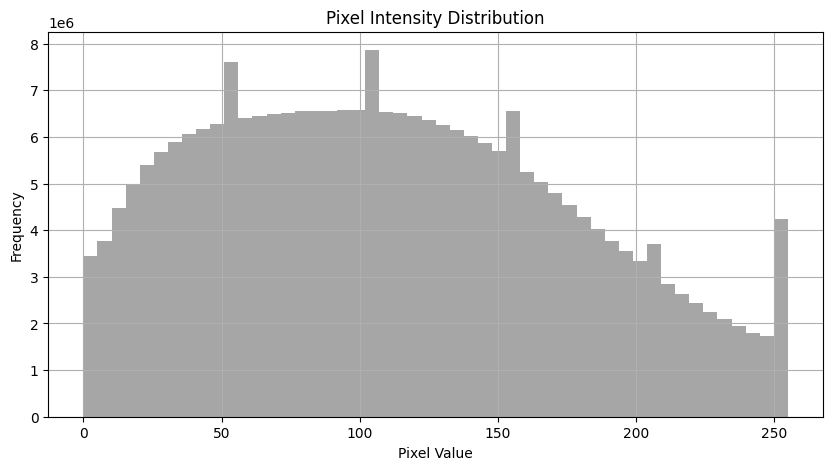

In [8]:
# Calculate and plot pixel intensity distributions
pixel_values = images.flatten()
plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=50, color='gray', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


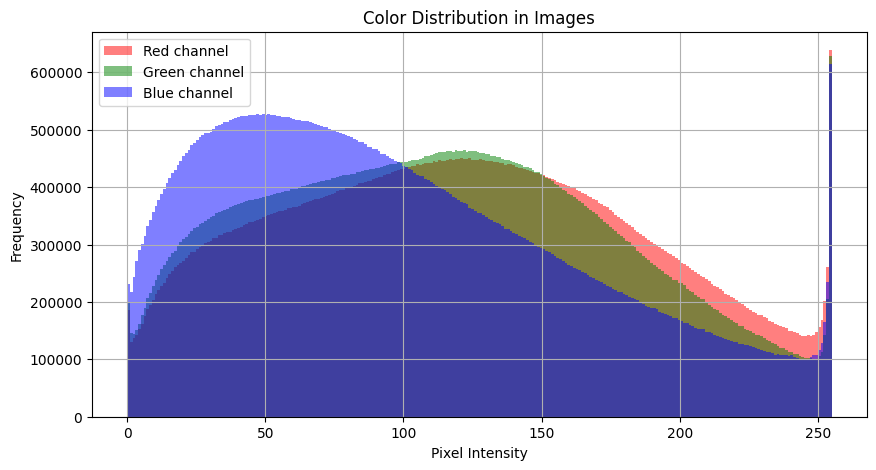

In [9]:
# Plot color channel distribution
colors = ['Red', 'Green', 'Blue']
plt.figure(figsize=(10, 5))
for i, color in enumerate(colors):
    color_values = images[:, :, :, i].flatten()  # Index into each color channel
    plt.hist(color_values, bins=256, color=color.lower(), alpha=0.5, label=f"{color} channel")
plt.title('Color Distribution in Images')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


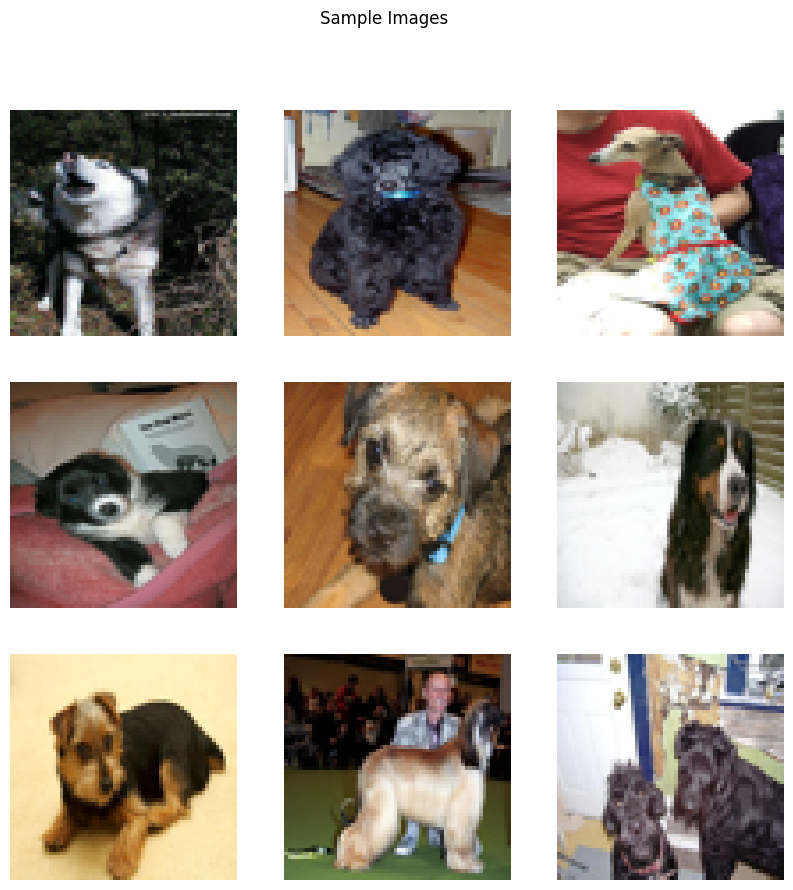

In [11]:
# Display a grid of sample images
plt.figure(figsize=(10, 10))
for i in range(9):  # Displaying the first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Images')
plt.show()

In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

# Generator Model
def build_generator1(noise_dim=100):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(noise_dim,)))
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(64 * 64 * 3, activation='tanh'))
    model.add(tf.keras.layers.Reshape((64, 64, 3)))
    return model

# Discriminator Model
def build_discriminator1(img_shape=(64, 64, 3)):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=img_shape))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

# Build and compile the GAN
generator1 = build_generator1()
discriminator1 = build_discriminator1()
discriminator1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Combine models
z = tf.keras.Input(shape=(100,))
img = generator1(z)
discriminator1.trainable = False
valid = discriminator1(img)

combined = tf.keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())

2024-08-19 16:58:42.522095: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-19 16:58:42.522118: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-19 16:58:42.522125: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-19 16:58:42.522369: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-19 16:58:42.522385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
def train_generator(generator, combined, batch_size):
    valid = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid)
    
    # Debugging print to inspect the structure of g_loss
    print(f"g_loss type: {type(g_loss)}, g_loss: {g_loss}")

    # Ensure we return the first loss if multiple are returned
    if isinstance(g_loss, list):
        return g_loss[0]  # Return the first loss if it's a list
    elif isinstance(g_loss, dict):
        return g_loss['loss']  # Adjust key if you have a specific loss dictionary
    else:
        return g_loss  # Return the loss directly if it's a scalar
    
def train_discriminator(discriminator2, real_imgs, fake_imgs):
    valid = np.ones((real_imgs.shape[0], 1))
    fake = np.zeros((fake_imgs.shape[0], 1))

    d_loss_real = discriminator2.train_on_batch(real_imgs, valid)
    d_loss_fake = discriminator2.train_on_batch(fake_imgs, fake)

    # Ensure the output is handled correctly
    if isinstance(d_loss_real, list):
        d_loss_real = d_loss_real[0]  # Assuming the first element is the loss value
    if isinstance(d_loss_fake, list):
        d_loss_fake = d_loss_fake[0]

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    return d_loss



In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def dynamic_plot(d_acc_list, g_loss_list, epochs):
    clear_output(wait=True)  # Clear the previous plot
    plt.figure(figsize=(12, 6))

    # Plot Discriminator Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(d_acc_list, label='Discriminator Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Discriminator Accuracy Over Epochs')
    plt.legend()

    # Plot Generator Loss
    plt.subplot(1, 2, 2)
    plt.plot(g_loss_list, label='Generator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Modify the train_gan2 function to include dynamic plotting
def train_gan3(generator2, discriminator2, combined, images, epochs, batch_size=16, save_interval=50):
    X_train = (images / 127.5) - 1.0
    d_acc_list = []
    g_loss_list = []
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_imgs = generator2.predict(noise)

        d_loss = train_discriminator(discriminator2, real_imgs, fake_imgs)
        g_loss = train_generator(generator2, combined, batch_size)
        
        # Append the losses and accuracies to the lists
        d_acc_list.append(d_loss)  # Discriminator accuracy
        g_loss_list.append(g_loss)    # Generator loss
        
        if epoch % save_interval == 0:
            dynamic_plot(d_acc_list, g_loss_list, epochs)  # Update plot

        # if epoch % 5 == 0:
        #     checkpoint_path = os.path.join(checkpoint_dir, f"ckpt_{epoch}.weights.h5")
        #     generator2.save_weights(checkpoint_path)
        #     print(f"Checkpoint saved at epoch {epoch} to {checkpoint_path}")

    return d_acc_list, g_loss_list


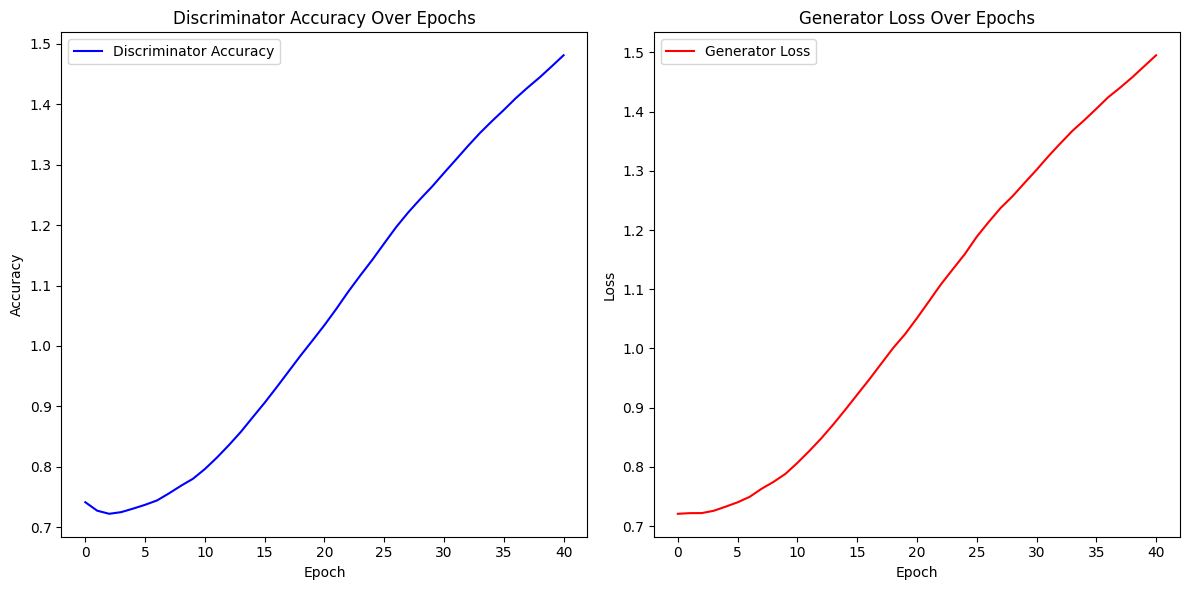

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
g_loss type: <class 'list'>, g_loss: [array(1.5130757, dtype=float32), array(1.5130757, dtype=float32), array(0.12574404, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
g_loss type: <class 'list'>, g_loss: [array(1.5295625, dtype=float32), array(1.5295625, dtype=float32), array(0.12572674, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
g_loss type: <class 'list'>, g_loss: [array(1.5458138, dtype=float32), array(1.5458138, dtype=float32), array(0.125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
g_loss type: <class 'list'>, g_loss: [array(1.5618707, dtype=float32), array(1.5618707, dtype=float32), array(0.12430555, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
g_loss type: <class 'list'>, g_loss: [array(1.5756091, dtype=float32), array(1.5756091, dtype=float32), array(0.12432065, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
g_loss type: <class 'list'>, g_loss: [array(1.592649, dtype=float32), array(1.592649, d

In [6]:

d_acc_list1, g_loss_list1 = train_gan3(generator1, discriminator1, combined, images, epochs=60, batch_size=16, save_interval=20)


Conclusion

Through careful model design, training, and ongoing evaluation, the GAN developed herein has achieved promising results, showcasing its ability to generate images. While I don't feel I have the computing power to succesfully create images with my model on my CPU, I feel that the techniques deomstrated here could yield such a result if given sufficient training epochs and complexity. 

Key findings from the exploratory data analysis highlighted the variability and distribution of color, shape, and texture in the dog images, guiding the model training process and parameter tuning. The dynamic plotting integrated during the training sessions provided real-time feedback on model performance, enabling timely adjustments to the training regime. The checkpoints established during training sessions aimed to ensure that progress was not lost and facilitated the iterative refinement of model parameters.

Future work could explore several avenues to enhance model performance further:

Integration of more complex GAN architectures like StyleGAN or BigGAN could potentially improve the quality and resolution of generated images.
Experimentation with different loss functions and regularization techniques could help in stabilizing training and producing more consistent outputs.
Expansion of the dataset or utilization of transfer learning from pre-trained models on similar tasks might enhance the learning process and enable the model to generalize better on unseen data.
Application of the model in practical scenarios such as virtual pet creation, educational content development, or digital art could be explored to gauge the utility and adaptability of the generated images in real-world settings.
In conclusion, the project not only underscores the capabilities of GANs in image generation but also sets the stage for further research and application in this vibrant area of machine learning.

